In [1]:
import zipfile

with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
train=pd.read_csv("data/Corona_NLP_train.csv", encoding='latin1')
test=pd.read_csv("data/Corona_NLP_test.csv", encoding='latin1')
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
print(train.info())
print(train["Sentiment"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


In [4]:
import re
import string

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    text = re.sub(r'@\w+', '', text)

    text = re.sub(r'#\w+', '', text)

    text = re.sub(r'&\w+;', '', text)

    text = text.encode('ascii', 'ignore').decode('ascii')

    text = text.translate(str.maketrans('', '', string.punctuation))

    text = re.sub(r'\d+', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    text = text.lower()

    return text

In [5]:
train['OriginalTweet']=train['OriginalTweet'].apply(clean_text)
test['OriginalTweet']=test['OriginalTweet'].apply(clean_text)
mapping = {
    "Extremely Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Extremely Positive": 4
}

train["Sentiment"] = train["Sentiment"].map(mapping)
test["Sentiment"] = test["Sentiment"].map(mapping)
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,and and,2
1,3800,48752,UK,16-03-2020,advice talk to your neighbours family to excha...,3
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths to give elder...,3
3,3802,48754,NaN,16-03-2020,my food stock is not the only one which is emp...,3
4,3803,48755,NaN,16-03-2020,me ready to go at supermarket during the outbr...,0


In [6]:

x_train=train["OriginalTweet"].values
y_train=train["Sentiment"].values
x_test=test["OriginalTweet"].values
y_test=test["Sentiment"].values
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(41157,)
(41157,)
(3798,)
(3798,)


In [7]:
print(x_train[7],y_train[7])

was at the supermarket today didnt buy toilet paper 2


In [8]:
max_words = 10000   
max_len = 50     

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

### LSTM 

In [9]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D,SpatialDropout1D,BatchNormalization
from tensorflow.keras.regularizers import l2

embedding_dim = 128

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_lstm.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.5,
                              recurrent_dropout=0.2,
                              kernel_regularizer=l2(0.002),
                                  
                              )))
model_lstm.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.5,
                              recurrent_dropout=0.2,
                              kernel_regularizer=l2(0.001),
                                   
                              )))
model_lstm.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
#model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(5, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.build(input_shape=(None, max_len))
model_lstm.summary()

C:\Users\aldawlia\Desktop\tf\tfvenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,945,797 (7.42 MB)

 Trainable params: 1,945,797 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
X_train_pad[0]

array([4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=3,            
    restore_best_weights=True  
)

checkpoint = ModelCheckpoint(
    'best_model_0.h5',      
    monitor='val_loss',
    save_best_only=True
)

history = model_lstm.fit(
    X_train_pad,
    y_train,
    epochs=20,             
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.3034 - loss: 1.7737

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 552s 497ms/step - accuracy: 0.3035 - loss: 1.7735 - val_accuracy: 0.5244 - val_loss: 1.2227
Epoch 2/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.5222 - loss: 1.2370

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 728s 708ms/step - accuracy: 0.5222 - loss: 1.2370 - val_accuracy: 0.6958 - val_loss: 0.9106
Epoch 3/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6824 - loss: 0.9443

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 455s 442ms/step - accuracy: 0.6824 - loss: 0.9443 - val_accuracy: 0.7439 - val_loss: 0.7905
Epoch 4/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7602 - loss: 0.7886

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 492s 478ms/step - accuracy: 0.7602 - loss: 0.7886 - val_accuracy: 0.7754 - val_loss: 0.7788
Epoch 5/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7887 - loss: 0.7307

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 534s 519ms/step - accuracy: 0.7887 - loss: 0.7307 - val_accuracy: 0.7828 - val_loss: 0.7042
Epoch 6/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 768s 746ms/step - accuracy: 0.8057 - loss: 0.6887 - val_accuracy: 0.7869 - val_loss: 0.7206
Epoch 7/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 238s 232ms/step - accuracy: 0.8167 - loss: 0.6552 - val_accuracy: 0.7885 - val_loss: 0.7135
Epoch 8/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 256s 248ms/step - accuracy: 0.8300 - loss: 0.6237 - val_accuracy: 0.7775 - val_loss: 0.7394


In [12]:
loss, acc = model_lstm.evaluate(X_test_pad, y_test)
print("Test Acc", acc)
print("Test Loss", loss)


119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7468 - loss: 0.7937
Test Acc 0.7525013089179993
Test Loss 0.7743250727653503


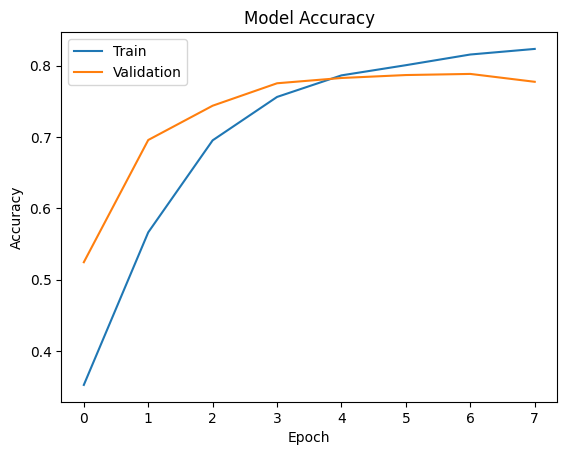

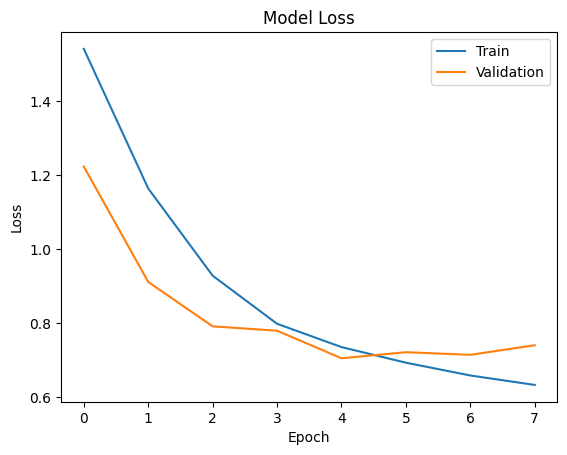

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()


## GRU

In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, GlobalMaxPooling1D,SpatialDropout1D,BatchNormalization
from tensorflow.keras.regularizers import l2

embedding_dim = 128

model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model_gru.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.5,
                              recurrent_dropout=0.2,
                              kernel_regularizer=l2(0.001),
                                  
                              )))
model_gru.add(Bidirectional(GRU(128, return_sequences=False, dropout=0.5,
                              recurrent_dropout=0.2,
                              kernel_regularizer=l2(0.001),
                                   
                              )))
model_gru.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(5, activation='softmax'))

model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.build(input_shape=(None, max_len))
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 50, 256)             │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,782,981 (6.80 MB)

 Trainable params: 1,782,981 (6.80 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=3,            
    restore_best_weights=True  
)

checkpoint = ModelCheckpoint(
    'best_model_1.h5',      
    monitor='val_loss',
    save_best_only=True
)

history = model_gru.fit(
    X_train_pad,
    y_train,
    epochs=20,             
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2922 - loss: 1.7291

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 251s 229ms/step - accuracy: 0.2923 - loss: 1.7289 - val_accuracy: 0.5294 - val_loss: 1.1881
Epoch 2/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5675 - loss: 1.1208

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 232s 226ms/step - accuracy: 0.5675 - loss: 1.1208 - val_accuracy: 0.7536 - val_loss: 0.7592
Epoch 3/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7329 - loss: 0.8009

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 235s 229ms/step - accuracy: 0.7329 - loss: 0.8009 - val_accuracy: 0.7692 - val_loss: 0.7366
Epoch 4/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7846 - loss: 0.7037

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 235s 228ms/step - accuracy: 0.7846 - loss: 0.7037 - val_accuracy: 0.7875 - val_loss: 0.6815
Epoch 5/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 232s 225ms/step - accuracy: 0.8125 - loss: 0.6406 - val_accuracy: 0.7924 - val_loss: 0.6860
Epoch 6/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 233s 227ms/step - accuracy: 0.8272 - loss: 0.5977 - val_accuracy: 0.7980 - val_loss: 0.7228
Epoch 7/20
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 237s 231ms/step - accuracy: 0.8343 - loss: 0.6026 - val_accuracy: 0.8030 - val_loss: 0.6903


In [19]:
loss, acc = model_gru.evaluate(X_test_pad, y_test)
print("Test Acc", acc)
print("Test Loss", loss)


119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7489 - loss: 0.7863
Test Acc 0.7540810704231262
Test Loss 0.7663124799728394


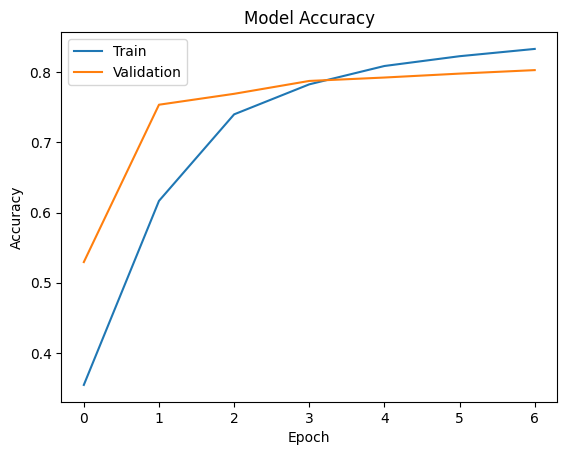

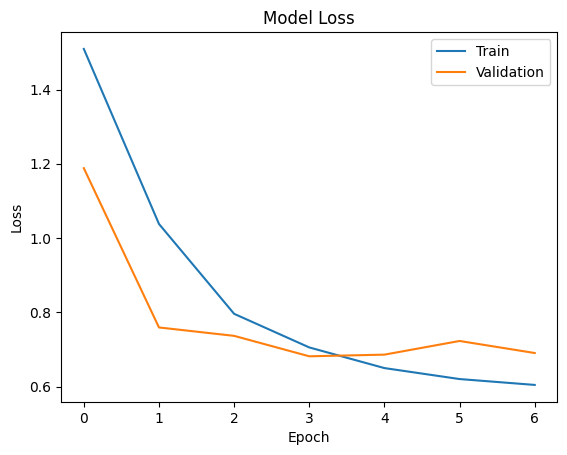

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()
